<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот Ноутбук является Примером/Шаблоном (Baseline) к этому соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

In [2]:
pip install progressbar

  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12074 sha256=bb49e94bf0d8d0c3325fab3b7c4d6bec982eab837aa979add41edc1c65720f52
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from nltk.corpus import stopwords
import nltk
import re
import math
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor, BaggingRegressor, StackingRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from catboost import CatBoostRegressor
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import sys
import numpy as np  # linear algebra
import pandas as pd
from progressbar import ProgressBar
pbar = ProgressBar()

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [5]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [7]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# 0. Setup

In [8]:
VERSION = 16
VAL_SIZE = 0.20   # 20%

In [9]:
!ls '../input'

parsing-all-moscow-auto-ru-09-09-2020  train-dataset-autoru
sf-dst-car-price-prediction


# 1. Data
- parsing code you'll find in notebook - `auroru_parsing` in github repository 
- train dataset consist about 89.6K raws
- as parsing took a lot of time i didn't get 80/20 split
- as result we have 19 features
- a lot of empty values
## 1.1 Data preprocessing
- I did preprocessing work in `prepare_dataset_forkaggle`notebook, which you can find in github repository
insights & changes were made in preprocessing:
- deleted uninformative features, 
- recalled the columns names, 
- all values in cloluns have the same format
- same dtypes 
- as test dataset is avalible in kaggle at first I'll remove some features 
- most of features are categorical


In [10]:
# reading data sets
# датасет для обучения модели
train = pd.read_csv('../input/train-dataset-autoru/data_for_kaggle.csv')
test = pd.read_csv('../input/sf-dst-car-price-prediction/test.csv')
sample_submission = pd.read_csv(
    '../input/sf-dst-car-price-prediction/sample_submission.csv')

In [11]:
sample_submission

sell_id  price
0      1100575026      0
1      1100549428      0
2      1100658222      0
3      1100937408      0
4      1101037972      0
...           ...    ...
34681  1101369263      0
34682  1101369581      0
34683  1101364889      0
34684  1101362518      0
34685  1101256068      0

[34686 rows x 2 columns]

In [12]:
# first look into t
train = train.sort_index(axis=1)
train.head(2).T

0  \
bodyType                                                         седан   
brand                                                              BMW   
color                                                           чёрный   
description          Продаю авто, за время владения было не мало чт...   
engineDisplacement                                             2.5 LTR   
enginePower                                                    170 N12   
fuelType                                                        бензин   
mileage                                                         226000   
model_name                                                           5   
price                                                           155000   
productionDate                                                    1988   
vehicleTransmission                                       механическая   
vendor                                                        EUROPEAN   
Владельцы                                                  3 или более   
Владение                                                           NaN   
ПТС                                                           Оригинал   
Привод                                                          задний   
Руль                                                             Левый   
Состояние                                           Не требует ремонта   
Таможня                                                     Растаможен   

                                                                     1  
bodyType                                             внедорожник 5 дв.  
brand                                                              BMW  
color                                                            белый  
description          Дилерский авто , в матовой  защитной пленке  (...  
engineDisplacement                                             4.4 LTR  
enginePower                                                    555 N12  
fuelType                                                        бензин  
mileage                                                          75000  
model_name                                                          X6  
price                                                          1950000  
productionDate                                                    2013  
vehicleTransmission                                     автоматическая  
vendor                                                        EUROPEAN  
Владельцы                                                  2 владельца  
Владение                                             6 лет и 9 месяцев  
ПТС                                                           Оригинал  
Привод                                                          полный  
Руль                                                             Левый  
Состояние                                           Не требует ремонта  
Таможня                                                     Растаможен

In [13]:
test = test.drop(columns=['car_url', 'complectation_dict', 'equipment_dict', 'image', 'modelDate',
                          'model_info', 'name', 'numberOfDoors', 'parsing_unixtime',
                          'priceCurrency', 'sell_id', 'super_gen', 'vehicleConfiguration'])
test = test.sort_index(axis=1)
test.head(2).T

0  \
bodyType                                                       лифтбек   
brand                                                            SKODA   
color                                                            синий   
description          Все автомобили, представленные в продаже, прох...   
engineDisplacement                                             1.2 LTR   
enginePower                                                    105 N12   
fuelType                                                        бензин   
mileage                                                          74000   
model_name                                                     OCTAVIA   
productionDate                                                    2014   
vehicleTransmission                                   роботизированная   
vendor                                                        EUROPEAN   
Владельцы                                                  3 или более   
Владение                                                           NaN   
ПТС                                                           Оригинал   
Привод                                                        передний   
Руль                                                             Левый   
Состояние                                           Не требует ремонта   
Таможня                                                     Растаможен   

                                                                     1  
bodyType                                                       лифтбек  
brand                                                            SKODA  
color                                                           чёрный  
description          ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...  
engineDisplacement                                             1.6 LTR  
enginePower                                                    110 N12  
fuelType                                                        бензин  
mileage                                                          60563  
model_name                                                     OCTAVIA  
productionDate                                                    2017  
vehicleTransmission                                       механическая  
vendor                                                        EUROPEAN  
Владельцы                                                   1 владелец  
Владение                                                           NaN  
ПТС                                                           Оригинал  
Привод                                                        передний  
Руль                                                             Левый  
Состояние                                           Не требует ремонта  
Таможня                                                     Растаможен

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89668 entries, 0 to 89667
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bodyType             89666 non-null  object
 1   brand                89668 non-null  object
 2   color                89668 non-null  object
 3   description          89660 non-null  object
 4   engineDisplacement   89668 non-null  object
 5   enginePower          89666 non-null  object
 6   fuelType             89666 non-null  object
 7   mileage              89668 non-null  int64 
 8   model_name           89668 non-null  object
 9   price                89668 non-null  int64 
 10  productionDate       89668 non-null  int64 
 11  vehicleTransmission  89666 non-null  object
 12  vendor               89668 non-null  object
 13  Владельцы            89663 non-null  object
 14  Владение             25313 non-null  object
 15  ПТС                  89666 non-null  object
 16  Прив

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bodyType             34686 non-null  object
 1   brand                34686 non-null  object
 2   color                34686 non-null  object
 3   description          34686 non-null  object
 4   engineDisplacement   34686 non-null  object
 5   enginePower          34686 non-null  object
 6   fuelType             34686 non-null  object
 7   mileage              34686 non-null  int64 
 8   model_name           34686 non-null  object
 9   productionDate       34686 non-null  int64 
 10  vehicleTransmission  34686 non-null  object
 11  vendor               34686 non-null  object
 12  Владельцы            34686 non-null  object
 13  Владение             11995 non-null  object
 14  ПТС                  34685 non-null  object
 15  Привод               34686 non-null  object
 16  Руль

### 

In [16]:
# for identical feature preprocessing i'll concatenate both datasets
train['sample'] = 1  # mark with 1 train dataset
test['sample'] = 0  # mark with 0 test dataset

data = test.append(train, sort=False).reset_index(drop=True)  # объединяем

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124354 entries, 0 to 124353
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             124352 non-null  object 
 1   brand                124354 non-null  object 
 2   color                124354 non-null  object 
 3   description          124346 non-null  object 
 4   engineDisplacement   124354 non-null  object 
 5   enginePower          124352 non-null  object 
 6   fuelType             124352 non-null  object 
 7   mileage              124354 non-null  int64  
 8   model_name           124354 non-null  object 
 9   productionDate       124354 non-null  int64  
 10  vehicleTransmission  124352 non-null  object 
 11  vendor               124354 non-null  object 
 12  Владельцы            124349 non-null  object 
 13  Владение             37308 non-null   object 
 14  ПТС                  124351 non-null  object 
 15  Привод           

In [18]:
data.head(3).T

0  \
bodyType                                                       лифтбек   
brand                                                            SKODA   
color                                                            синий   
description          Все автомобили, представленные в продаже, прох...   
engineDisplacement                                             1.2 LTR   
enginePower                                                    105 N12   
fuelType                                                        бензин   
mileage                                                          74000   
model_name                                                     OCTAVIA   
productionDate                                                    2014   
vehicleTransmission                                   роботизированная   
vendor                                                        EUROPEAN   
Владельцы                                                  3 или более   
Владение                                                           NaN   
ПТС                                                           Оригинал   
Привод                                                        передний   
Руль                                                             Левый   
Состояние                                           Не требует ремонта   
Таможня                                                     Растаможен   
sample                                                               0   
price                                                              NaN   

                                                                     1  \
bodyType                                                       лифтбек   
brand                                                            SKODA   
color                                                           чёрный   
description          ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...   
engineDisplacement                                             1.6 LTR   
enginePower                                                    110 N12   
fuelType                                                        бензин   
mileage                                                          60563   
model_name                                                     OCTAVIA   
productionDate                                                    2017   
vehicleTransmission                                       механическая   
vendor                                                        EUROPEAN   
Владельцы                                                   1 владелец   
Владение                                                           NaN   
ПТС                                                           Оригинал   
Привод                                                        передний   
Руль                                                             Левый   
Состояние                                           Не требует ремонта   
Таможня                                                     Растаможен   
sample                                                               0   
price                                                              NaN   

                                                                     2  
bodyType                                                       лифтбек  
brand                                                            SKODA  
color                                                            серый  
description          Все автомобили, представленные в продаже, прох...  
engineDisplacement                                             1.8 LTR  
enginePower                                                    152 N12  
fuelType                                                        бензин  
mileage                                                          88000  
model_name                                                      SUPERB  
productionDate                                                    2014  
vehicleT

In [19]:
data.isna().sum()

bodyType                   2
brand                      0
color                      0
description                8
engineDisplacement         0
enginePower                2
fuelType                   2
mileage                    0
model_name                 0
productionDate             0
vehicleTransmission        2
vendor                     0
Владельцы                  5
Владение               87046
ПТС                        3
Привод                     2
Руль                       0
Состояние                  0
Таможня                    0
sample                     0
price                  34686
dtype: int64

In [20]:
# Владение has to many empty values - it is easier to delete this feature from zhe dataset
data = data.drop(columns=['Владение'])

# 2. EDA


In [21]:
# function which will used often in the notebook
# print unique vlaues & number of NAN's
def feature_info(feature):
    print('TRAIN dataset: ')
    print('number of unique values in feature \n', len(
        data[data['sample'] == 1][feature].unique()))
    print('unique vlaues', data[feature].unique())
    print('number of NANs \n', data[feature].isna().sum())
    print('TEST dataset: ')
    print('number of unique values in feature \n', len(
        data[data['sample'] == 0][feature].unique()))
    print('unique vlaues', data[feature].unique())
    print('number of NANs \n', data[feature].isna().sum())

# barplot


def barplot_function(feature):
    fig = plt.figure()
    axes = fig.add_axes([0, 0, 3, 1])
    sns.barplot(x=feature,
                y="count",
                hue="sample",
                data=data.groupby(['sample', feature])['sample'].count().sort_values(ascending=False).reset_index(name='count'))
    plt.xticks(rotation=60)
# boxplot


def boxplot_function(feature):
    # build boxplot to see the number of cuisines distribution in each rating score
    fig = plt.figure()
    axes = fig.add_axes([0, 0, 3, 1])
    axes.set_ylim(data.price.min(), data.price.mean() + 3*data.price.std())
    sns.boxplot(x=data[data['sample'] == 1][feature],
                y=data[data['sample'] == 1]['price'])
    # add description
    axes.set_xlabel(feature)
    axes.set_ylabel('price')
    plt.xticks(rotation=60)

### 2.1 bodyType
- `bodyType` distribition in both datasets is similar and we can consider dependencies between price and bodytype. 
- there are very many outliers, when we look into boxplot price destribution within bodyTypes 
- fillna with most common value for this car brand, model_name and production_year

In [22]:
feature_info('bodyType')

TRAIN dataset: 
number of unique values in feature 
 25
unique vlaues ['лифтбек' 'внедорожник 5 дв.' 'хэтчбек 5 дв.' 'седан' 'компактвэн'
 'универсал 5 дв.' 'пикап одинарная кабина' 'хэтчбек 3 дв.' 'купе'
 'кабриолет' 'минивэн' 'пикап двойная кабина' 'внедорожник 3 дв.'
 'родстер' 'микровэн' 'седан 2 дв.' 'купе-хардтоп' 'фастбек' 'тарга'
 'внедорожник открытый' 'лимузин' 'пикап полуторная кабина'
 'седан-хардтоп' 'фургон' 'универсал 3 дв.' nan]
number of NANs 
 2
TEST dataset: 
number of unique values in feature 
 24
unique vlaues ['лифтбек' 'внедорожник 5 дв.' 'хэтчбек 5 дв.' 'седан' 'компактвэн'
 'универсал 5 дв.' 'пикап одинарная кабина' 'хэтчбек 3 дв.' 'купе'
 'кабриолет' 'минивэн' 'пикап двойная кабина' 'внедорожник 3 дв.'
 'родстер' 'микровэн' 'седан 2 дв.' 'купе-хардтоп' 'фастбек' 'тарга'
 'внедорожник открытый' 'лимузин' 'пикап полуторная кабина'
 'седан-хардтоп' 'фургон' 'универсал 3 дв.' nan]
number of NANs 
 2


In [23]:
# check the information about the car
data[data['bodyType'].isna() == True]

bodyType  brand        color  \
76909       NaN  HONDA  серебристый   
121955      NaN  HONDA    пурпурный   

                                              description engineDisplacement  \
76909   Продаю Honda Civic Suttle 1989 г. выпуска, неу...            n.a LTR   
121955                        В хорошем состоянии на ходу            n.a LTR   

       enginePower fuelType  mileage model_name  productionDate  \
76909          NaN      NaN   400000      CIVIC            1989   
121955         NaN      NaN   220000      CIVIC            1989   

       vehicleTransmission    vendor    Владельцы       ПТС Привод   Руль  \
76909                  NaN  JAPANESE  3 или более  Оригинал    NaN  Левый   
121955                 NaN  JAPANESE  3 или более  Оригинал    NaN  Левый   

                 Состояние     Таможня  sample     price  
76909   Не требует ремонта  Растаможен       1  120000.0  
121955  Не требует ремонта  Растаможен       1  110000.0

In [24]:
# fill names with most common value for this brand and model
data[((data['brand'] == 'HONDA') & (data['model_name'] == 'CIVIC') & (
    data['productionDate'] == 1989))].groupby(['model_name', 'bodyType'])['model_name'].count()

model_name  bodyType     
CIVIC       хэтчбек 3 дв.    3
Name: model_name, dtype: int64

In [25]:
data['bodyType'] = data.bodyType.fillna('хэтчбек 3 дв.')

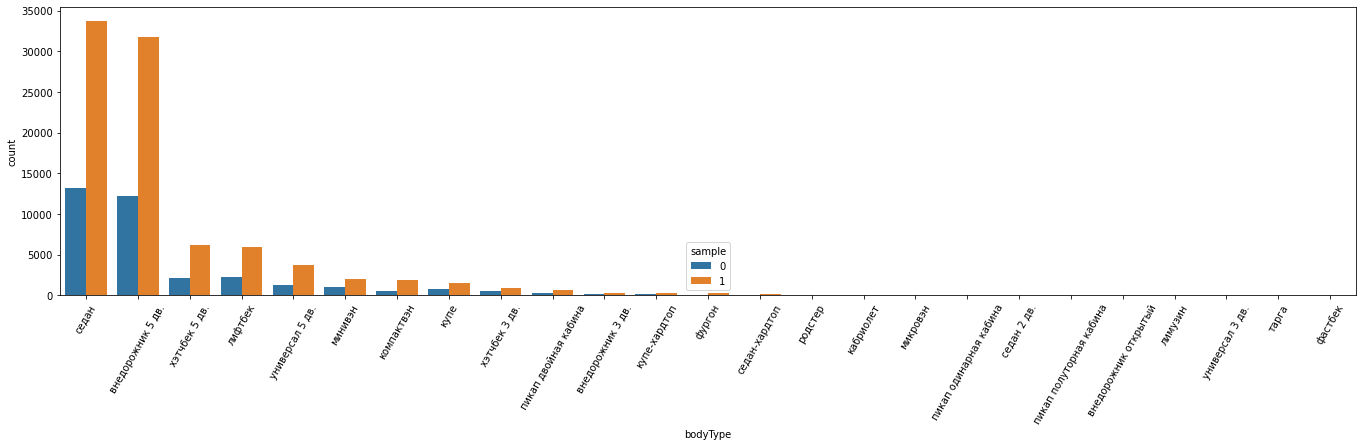

In [26]:
barplot_function('bodyType')

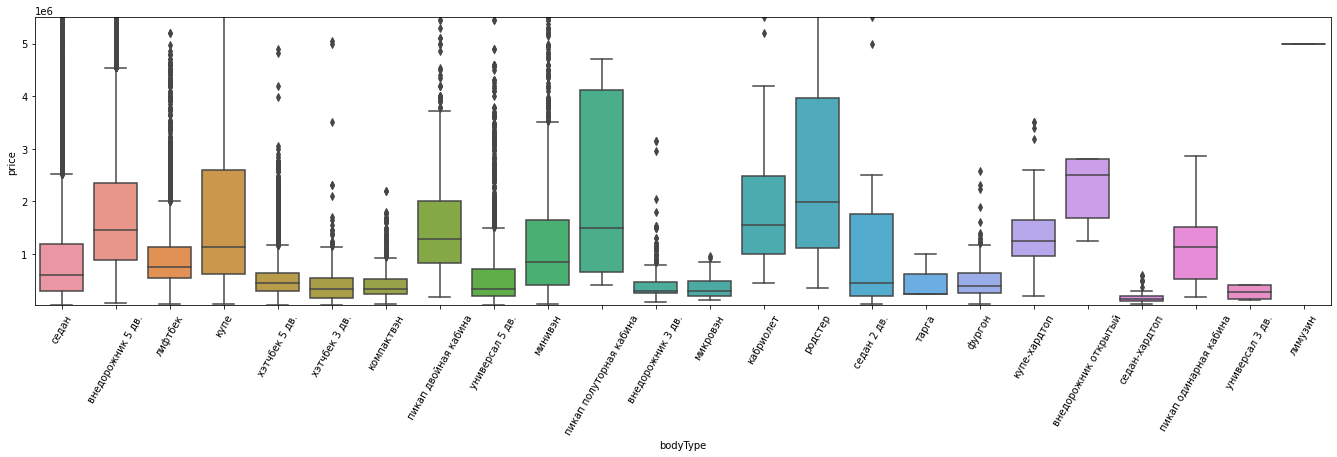

In [27]:
boxplot_function('bodyType')

### 2.2 brand
- 12 brands in both datasets
- no empty values
- similar distribution in both datasets
- dependencies between price within the brand


In [28]:
feature_info('brand')

TRAIN dataset: 
number of unique values in feature 
 12
unique vlaues ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']
number of NANs 
 0
TEST dataset: 
number of unique values in feature 
 12
unique vlaues ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']
number of NANs 
 0


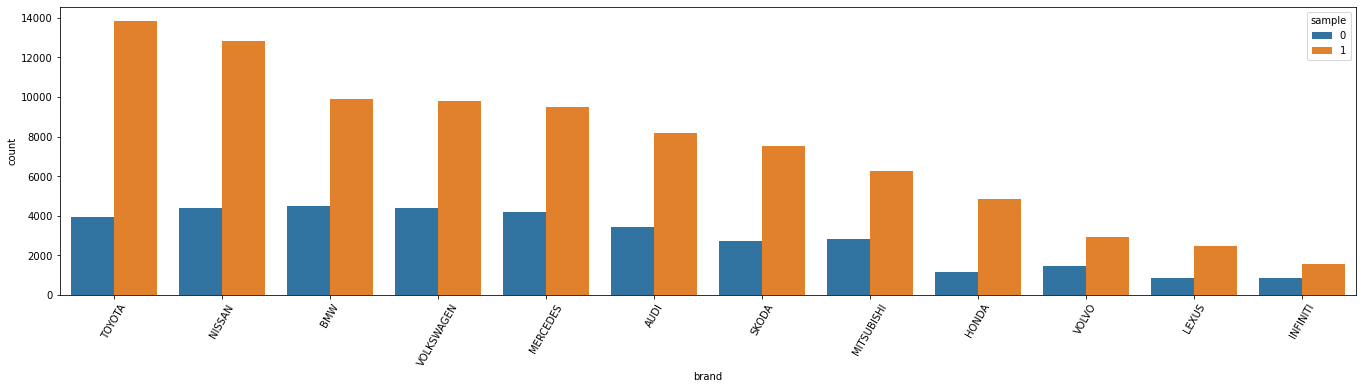

In [29]:
barplot_function('brand')

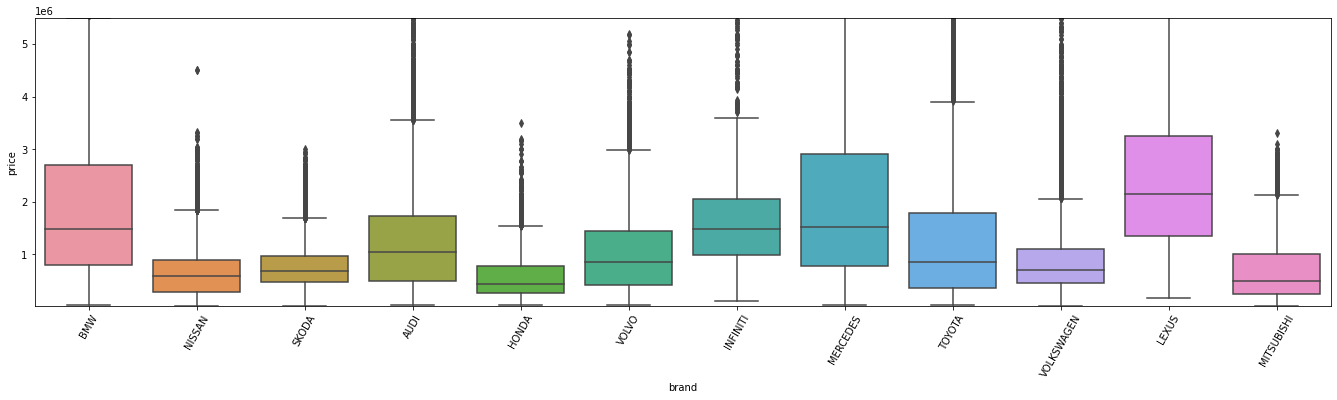

In [30]:
boxplot_function('brand')

### 2.3 color
- 16 values in both datasets
- no NaN's
- it seems like there are some dependencies between pricen within color


In [31]:
feature_info('color')

TRAIN dataset: 
number of unique values in feature 
 16
unique vlaues ['синий' 'чёрный' 'серый' 'коричневый' 'белый' 'пурпурный' 'бежевый'
 'серебристый' 'красный' 'зелёный' 'жёлтый' 'голубой' 'оранжевый'
 'фиолетовый' 'золотистый' 'розовый']
number of NANs 
 0
TEST dataset: 
number of unique values in feature 
 16
unique vlaues ['синий' 'чёрный' 'серый' 'коричневый' 'белый' 'пурпурный' 'бежевый'
 'серебристый' 'красный' 'зелёный' 'жёлтый' 'голубой' 'оранжевый'
 'фиолетовый' 'золотистый' 'розовый']
number of NANs 
 0


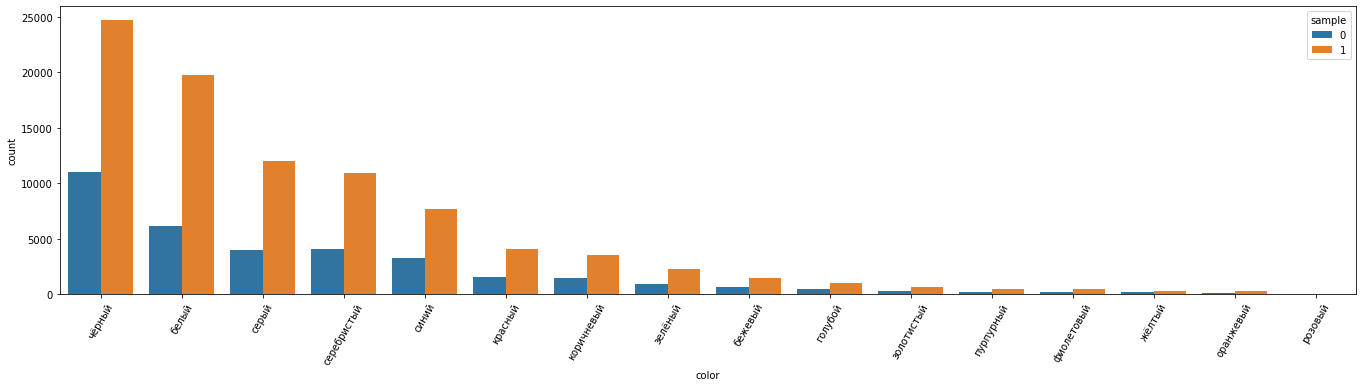

In [32]:
barplot_function('color')

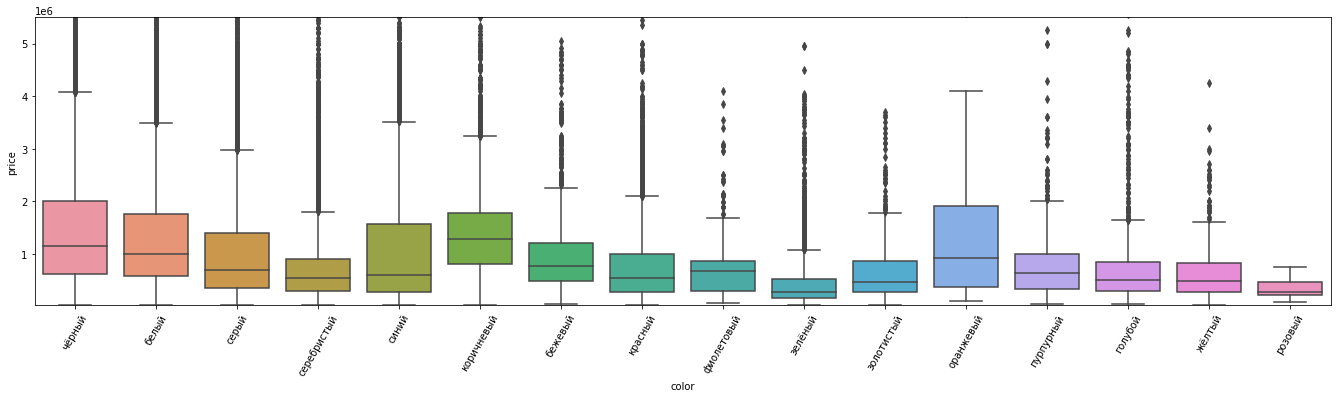

In [33]:
boxplot_function('color')

### 2.4 description
- `description` is a text feature written by seller contains the information about the car
- deleted all number, punktuation, brought all wors to lower case, created list of words for each car with description
- counted all words and created new dummy feater based on most common words , which may have an influence in price
- as not all new features had an ifluence on price desctibution, deleted this feater from dataset


In [34]:
data.description[2]

'Все автомобили, представленные в продаже, проходят тщательную проверку по более 40 параметрам. Предоставляем гарантию юридической чистоты, а так же год технической гарантии на двигатель и КПП. Бесплатный тест-драйв. Возможно оформление автомобиля в кредит!\n\nПреимущества автокредитования:\n— Первоначальный взнос от 0%;\n— Более 30 кредитных программ;\n— Процентная ставка от 6% годовых;\n— Срок кредита от 6 месяцев до 7 лет;\n— Оформление кредита по двум документам;\n— Досрочное погашение без штрафов и комиссий;\n— Сумма кредита до 2 млн рублей;\n— Оформление КАСКО – по желанию;\n— Без справок и поручителей.\n\nСотрудничаем с 12 аккредитованными и сертифицированными банками РФ, среднее время ожидания решения банка 20–30 минут.\n\nПри покупке автомобиля по программе «Trade-in – выгодный обмен» или в кредит, получите дополнительную скидку до 80 000 рублей на данный автомобиль!\n\nЗаписаться на тест-драйв, а так же получить подробную информацию можно у специалистов автоцентра по указанно

In [35]:
# Applying a first round of text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    #text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


# Applying the cleaning function to both test and training datasets
data['text'] = data['description'].astype(str).apply(lambda x: clean_text(x))


# Let's take a look at the updated text
data['text'].head()

0    все автомобили, представленные в продаже, прох...
1    лот:  северданный автомобиль прошел диагностик...
2    все автомобили, представленные в продаже, прох...
3    комплект зимней (летней) резины по сезону в по...
4    лот:  севервы можете получить скидку на данный...
Name: text, dtype: object

In [36]:
data['text'][2]

'все автомобили, представленные в продаже, проходят тщательную проверку по более  параметрам. предоставляем гарантию юридической чистоты, а так же год технической гарантии на двигатель и кпп. бесплатный тест-драйв. возможно оформление автомобиля в кредит!преимущества автокредитования:— первоначальный взнос от %;— более  кредитных программ;— процентная ставка от % годовых;— срок кредита от  месяцев до  лет;— оформление кредита по двум документам;— досрочное погашение без штрафов и комиссий;— сумма кредита до  млн рублей;— оформление каско – по желанию;— без справок и поручителей.сотрудничаем с  аккредитованными и сертифицированными банками рф, среднее время ожидания решения банка – минут.при покупке автомобиля по программе «trade-in – выгодный обмен» или в кредит, получите дополнительную скидку до   рублей на данный автомобиль!записаться на тест-драйв, а так же получить подробную информацию можно у специалистов автоцентра по указанному номеру телефона.'

In [37]:
# Tokenizing the training and the test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(lambda x: tokenizer.tokenize(x))

#create dictionary with wirds and their count
descripton = data['text']
import collections
c = collections.Counter()
for i in data.index:
    for category in descripton[i]:
        c[category] += 1

In [38]:
# create dummy variables with new information
list_of_commont_words_in_description = ['подушки безопасности', 'обогрев', 'подогрев', 'отличном состоянии', 'сигнализация',
                                        'хорошем состоянии', 'кондиционер', 'обслуживание',  'датчик', 'бортовой компьютер',
                                        'электростеклоподъемники', 'центральный замок', 'электропривод', 'подогрев', 'комплект', 'юридической',
                                        'круизконтроль']

for items in list_of_commont_words_in_description:
    data[items] = data['description'].astype(
        str).apply(lambda x: 1 if items in x else 0)

In [39]:
#check new features
data.head(2).T

0  \
bodyType                                                           лифтбек   
brand                                                                SKODA   
color                                                                синий   
description              Все автомобили, представленные в продаже, прох...   
engineDisplacement                                                 1.2 LTR   
enginePower                                                        105 N12   
fuelType                                                            бензин   
mileage                                                              74000   
model_name                                                         OCTAVIA   
productionDate                                                        2014   
vehicleTransmission                                       роботизированная   
vendor                                                            EUROPEAN   
Владельцы                                                      3 или более   
ПТС                                                               Оригинал   
Привод                                                            передний   
Руль                                                                 Левый   
Состояние                                               Не требует ремонта   
Таможня                                                         Растаможен   
sample                                                                   0   
price                                                                  NaN   
text                     [все, автомобили, представленные, в, продаже, ...   
подушки безопасности                                                     0   
обогрев                                                                  0   
подогрев                                                                 0   
отличном состоянии                                                       0   
сигнализация                                                             0   
хорошем состоянии                                                        0   
кондиционер                                                              0   
обслуживание                                                             0   
датчик                                                                   0   
бортовой компьютер                                                       0   
электростеклоподъемники                                                  0   
центральный замок                                                        0   
электропривод                                                            0   
комплект                                                                 0   
юридической                                                              1   
круизконтроль                                                            0   

                                                                         1  
bodyType                                                           лифтбек  
brand                                                                SKODA  
color                                                               чёрный  
description              ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...  
engineDisplacement                                                 1.6 LTR  
enginePower                                                        110 N12  
fuelType                                                            бензин  
mileage                                                              60563  
model_name                                                         OCTAVIA  
productionDate                                                        2017  
vehicleTransmission                                           механическая  
vendor                                                            EUROPEAN  
Владельцы                                                       1 владелец  
ПТС                           

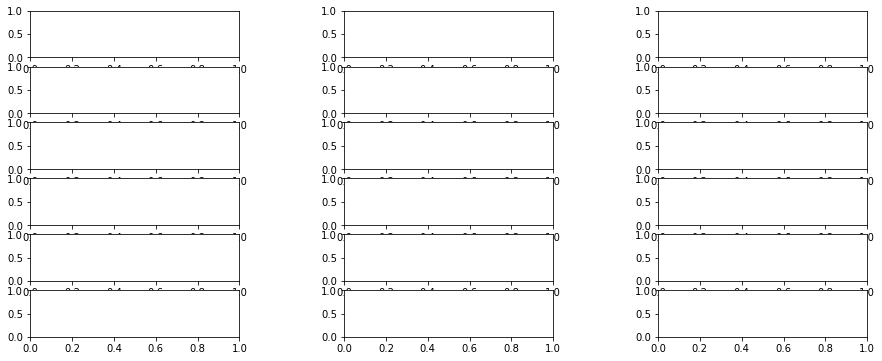

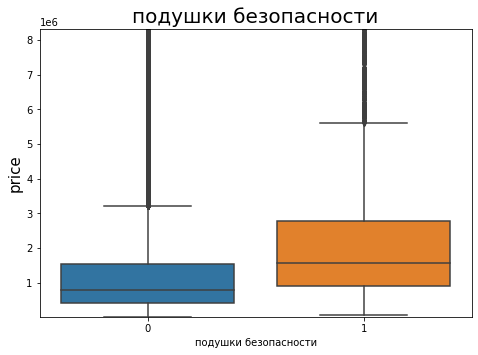

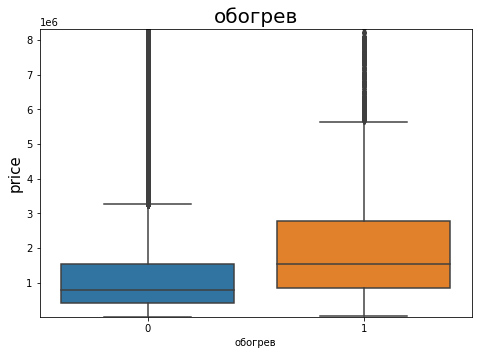

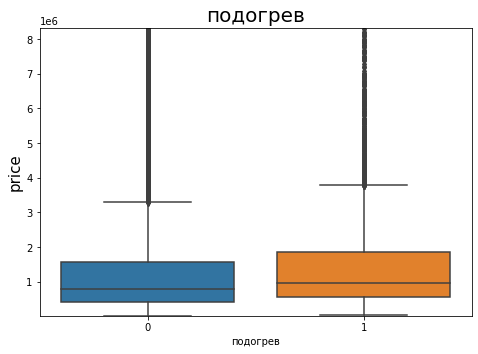

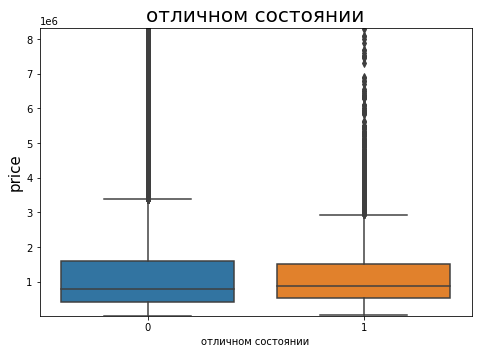

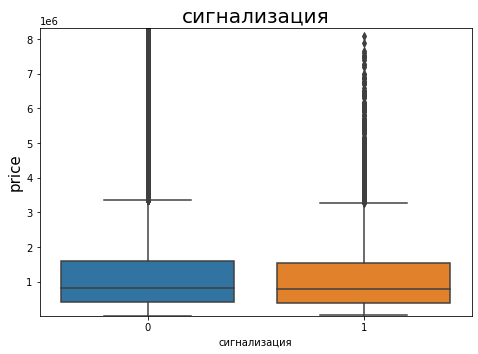

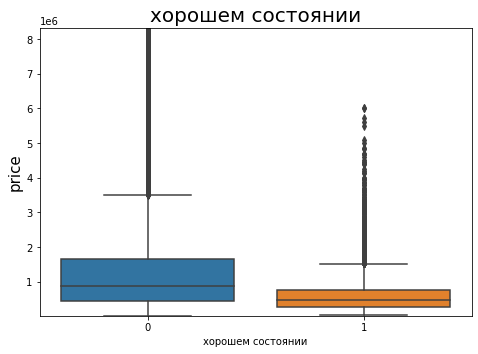

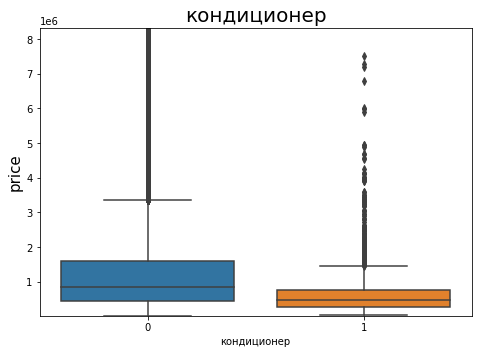

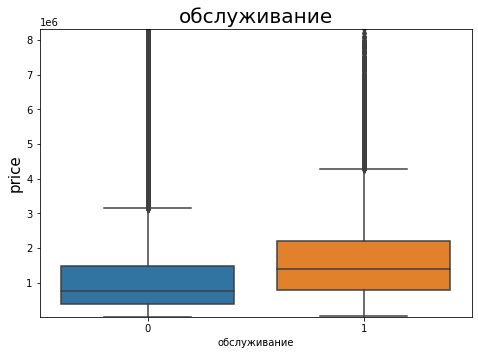

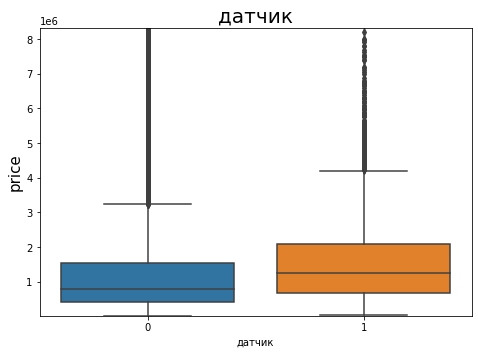

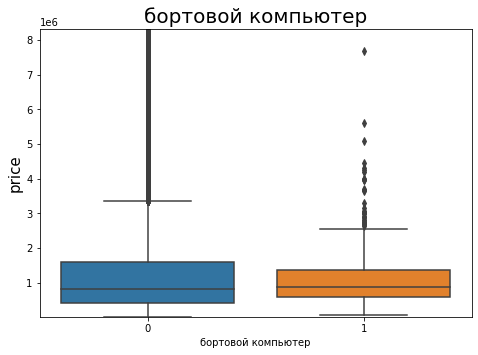

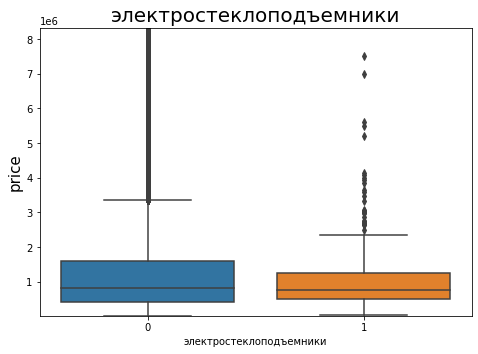

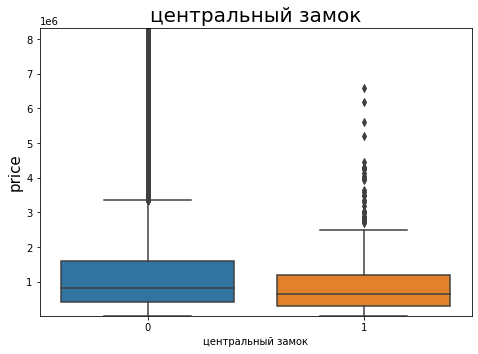

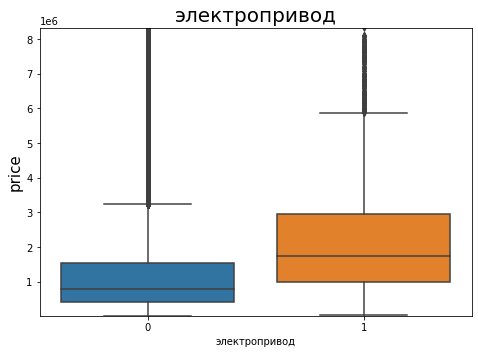

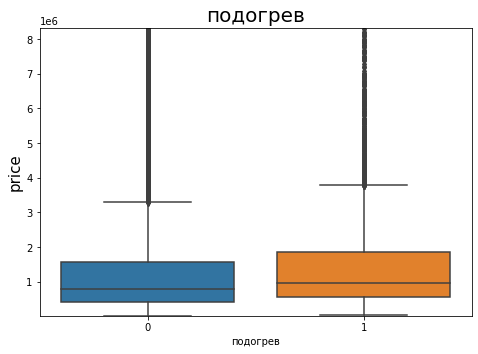

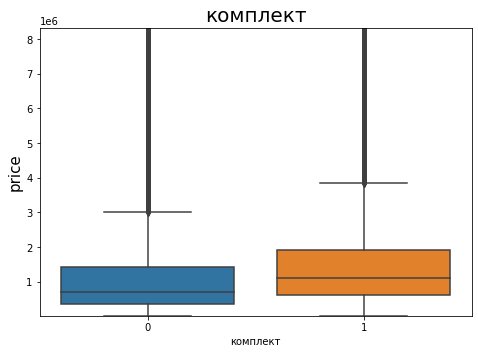

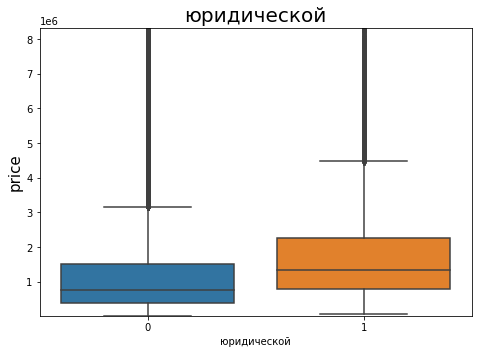

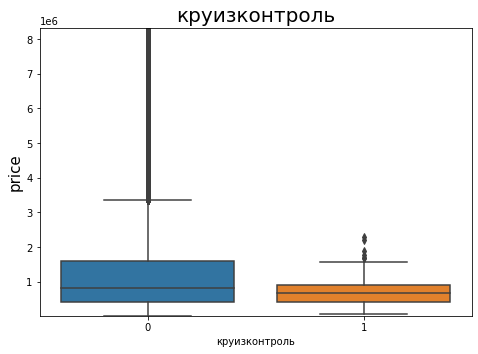

In [40]:
# check dependencies between price and new features
list_of_commont_words_in_description = ['подушки безопасности', 'обогрев', 'подогрев', 'отличном состоянии', 'сигнализация',
                                        'хорошем состоянии', 'кондиционер', 'обслуживание',  'датчик', 'бортовой компьютер',
                                        'электростеклоподъемники', 'центральный замок', 'электропривод', 'подогрев', 'комплект', 'юридической',
                                        'круизконтроль']
fig, axes = plt.subplots(6, 3, figsize=(15, 6))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()

for new_features in list_of_commont_words_in_description:
    fig = plt.figure()
    axes = fig.add_axes([0, 0, 1, 1])
    axes.set_ylim(data.price.min(), data.price.mean() + 5*data.price.std())
    g1 = sns.boxplot(y='price', x=new_features,
                     data=data)
    g1.set_title(new_features, fontsize=20)

    g1.set_ylabel("price", fontsize=15)
    plt.show()

In [41]:
# drop columns which have no big differences in price destribution within new features
data = data.drop(columns=['подогрев',  'отличном состоянии', 'сигнализация', 'бортовой компьютер',   'электростеклоподъемники',
                          'центральный замок', 'подогрев', 'комплект'])

In [42]:
data.head(2).T

0  \
bodyType                                                        лифтбек   
brand                                                             SKODA   
color                                                             синий   
description           Все автомобили, представленные в продаже, прох...   
engineDisplacement                                              1.2 LTR   
enginePower                                                     105 N12   
fuelType                                                         бензин   
mileage                                                           74000   
model_name                                                      OCTAVIA   
productionDate                                                     2014   
vehicleTransmission                                    роботизированная   
vendor                                                         EUROPEAN   
Владельцы                                                   3 или более   
ПТС                                                            Оригинал   
Привод                                                         передний   
Руль                                                              Левый   
Состояние                                            Не требует ремонта   
Таможня                                                      Растаможен   
sample                                                                0   
price                                                               NaN   
text                  [все, автомобили, представленные, в, продаже, ...   
подушки безопасности                                                  0   
обогрев                                                               0   
хорошем состоянии                                                     0   
кондиционер                                                           0   
обслуживание                                                          0   
датчик                                                                0   
электропривод                                                         0   
юридической                                                           1   
круизконтроль                                                         0   

                                                                      1  
bodyType                                                        лифтбек  
brand                                                             SKODA  
color                                                            чёрный  
description           ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...  
engineDisplacement                                              1.6 LTR  
enginePower                                                     110 N12  
fuelType                                                         бензин  
mileage                                                           60563  
model_name                                                      OCTAVIA  
productionDate                                                     2017  
vehicleTransmission                                        механическая  
vendor                                                         EUROPEAN  
Владельцы                                                    1 владелец  
ПТС                                                            Оригинал  
Привод                                                         передний  
Руль                                                              Левый  
Состояние                                            Не требует ремонта  
Таможня                                                      Растаможен  
sample                                                                0  
price                                                               NaN  
text                  [лот, северданный, автомобиль, прошел, диагнос...  
подушки безопасности                                                  0  
обогрев                                   

### 2.5 engineDisplacement
- there are no empty values
- emoty values replaced with most common values for thyt brand and models names and production year


In [43]:
feature_info('engineDisplacement')

TRAIN dataset: 
number of unique values in feature 
 56
unique vlaues ['1.2 LTR' '1.6 LTR' '1.8 LTR' '2.0 LTR' '1.4 LTR' '1.3 LTR' '1.0 LTR'
 '3.6 LTR' '1.5 LTR' '1.9 LTR' '2.8 LTR' '1.1 LTR' '2.5 LTR' '4.2 LTR'
 '3.0 LTR' '4.0 LTR' '5.9 LTR' '2.7 LTR' '3.1 LTR' '2.4 LTR' '5.2 LTR'
 '3.2 LTR' '4.1 LTR' '6.3 LTR' '2.3 LTR' '6.0 LTR' '2.2 LTR' '3.7 LTR'
 '2.9 LTR' '5.0 LTR' '3.3 LTR' '2.1 LTR' '2.6 LTR' ' LTR' '3.5 LTR'
 '1.7 LTR' '0.7 LTR' '4.4 LTR' '4.8 LTR' '5.4 LTR' '6.6 LTR' '4.9 LTR'
 '3.8 LTR' '3.4 LTR' '3.9 LTR' '4.6 LTR' '5.6 LTR' '4.5 LTR' '5.5 LTR'
 '6.2 LTR' '4.7 LTR' '4.3 LTR' '5.8 LTR' '5.3 LTR' '5.7 LTR' '6.7 LTR'
 '7.  LTR' '0.6 LTR' 'n.a LTR']
number of NANs 
 0
TEST dataset: 
number of unique values in feature 
 55
unique vlaues ['1.2 LTR' '1.6 LTR' '1.8 LTR' '2.0 LTR' '1.4 LTR' '1.3 LTR' '1.0 LTR'
 '3.6 LTR' '1.5 LTR' '1.9 LTR' '2.8 LTR' '1.1 LTR' '2.5 LTR' '4.2 LTR'
 '3.0 LTR' '4.0 LTR' '5.9 LTR' '2.7 LTR' '3.1 LTR' '2.4 LTR' '5.2 LTR'
 '3.2 LTR' '4.1 LTR' '6.3 LTR' '

In [44]:
data[data['engineDisplacement'] == 'n.a LTR']

bodyType  brand        color  \
76909   хэтчбек 3 дв.  HONDA  серебристый   
121955  хэтчбек 3 дв.  HONDA    пурпурный   

                                              description engineDisplacement  \
76909   Продаю Honda Civic Suttle 1989 г. выпуска, неу...            n.a LTR   
121955                        В хорошем состоянии на ходу            n.a LTR   

       enginePower fuelType  mileage model_name  productionDate  ...  \
76909          NaN      NaN   400000      CIVIC            1989  ...   
121955         NaN      NaN   220000      CIVIC            1989  ...   

                                                     text  \
76909   [продаю, honda, civic, suttle, г, выпуска, неу...   
121955                  [в, хорошем, состоянии, на, ходу]   

       подушки безопасности обогрев хорошем состоянии кондиционер  \
76909                     0       0                 0           0   
121955                    0       0                 1           0   

       обслуживание датчик электропривод  юридической  круизконтроль  
76909             0      0             0            0              0  
121955            0      0             0            0              0  

[2 rows x 30 columns]

In [45]:
# fill names with most common value for this brand and model
data[((data['brand'] == 'HONDA') & (data['model_name']
                                    == 'CIVIC') & (data['productionDate'] == 1989))]

bodyType  brand        color  \
32043   хэтчбек 3 дв.  HONDA  серебристый   
76430   хэтчбек 3 дв.  HONDA        белый   
76909   хэтчбек 3 дв.  HONDA  серебристый   
108707  хэтчбек 3 дв.  HONDA        белый   
121955  хэтчбек 3 дв.  HONDA    пурпурный   

                                              description engineDisplacement  \
32043   Всем привет, продам квадрат. \nБыл куплен мной...            1.4 LTR   
76430   Официальный дилерский центр РОЛЬФ Сити | Автом...            1.3 LTR   
76909   Продаю Honda Civic Suttle 1989 г. выпуска, неу...            n.a LTR   
108707  Официальный дилерский центр РОЛЬФ Сити | Автом...            1.3 LTR   
121955                        В хорошем состоянии на ходу            n.a LTR   

       enginePower fuelType  mileage model_name  productionDate  ...  \
32043       90 N12   бензин   285366      CIVIC            1989  ...   
76430       75 N12   бензин   378644      CIVIC            1989  ...   
76909          NaN      NaN   400000      CIVIC            1989  ...   
108707      75 N12   бензин   378644      CIVIC            1989  ...   
121955         NaN      NaN   220000      CIVIC            1989  ...   

                                                     text  \
32043   [всем, привет, продам, квадрат, был, куплен, м...   
76430   [официальный, дилерский, центр, рольф, сити, а...   
76909   [продаю, honda, civic, suttle, г, выпуска, неу...   
108707  [официальный, дилерский, центр, рольф, сити, а...   
121955                  [в, хорошем, состоянии, на, ходу]   

       подушки безопасности обогрев хорошем состоянии кондиционер  \
32043                     0       0                 0           0   
76430                     0       0                 0           0   
76909                     0       0                 0           0   
108707                    0       0                 0           0   
121955                    0       0                 1           0   

       обслуживание датчик электропривод  юридической  круизконтроль  
32043             0      0             0            0              0  
76430             1      0             0            1              0  
76909             0      0             0            0              0  
108707            1      0             0            1              0  
121955            0      0             0            0              0  

[5 rows x 30 columns]

In [46]:
# replace with most common  engineDisplacement value
data['engineDisplacement'] = data['engineDisplacement'].str.replace(
    'n.a LTR', '1.3 LTR')

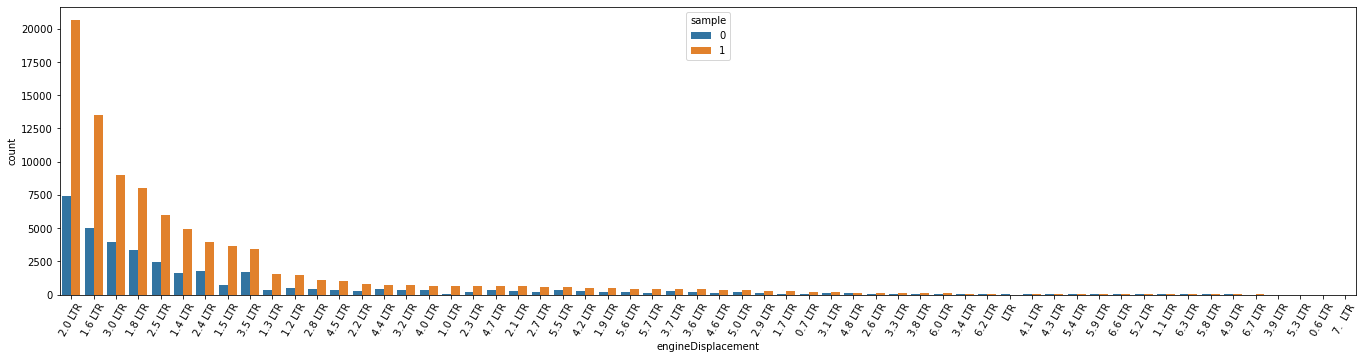

In [47]:
barplot_function('engineDisplacement')


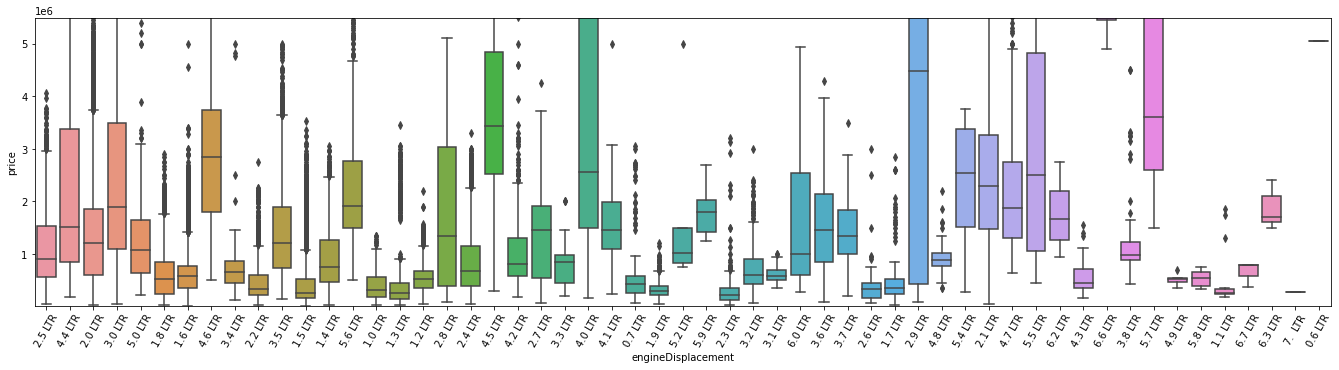

In [48]:
boxplot_function('engineDisplacement')

### 2.6 enginePower
- there are about 325 unique values 
- replaced 2 empty values
- it look like there are enginePower have an influence on price


In [49]:
feature_info('enginePower')

TRAIN dataset: 
number of unique values in feature 
 325
unique vlaues ['105 N12' '110 N12' '152 N12' '200 N12' '102 N12' '150 N12' '90 N12'
 '180 N12' '220 N12' '122 N12' '70 N12' '140 N12' '125 N12' '54 N12'
 '86 N12' '75 N12' '64 N12' '95 N12' '260 N12' '170 N12' '80 N12' '68 N12'
 '160 N12' '115 N12' '280 N12' '53 N12' '60 N12' '143 N12' '42 N12'
 '101 N12' '58 N12' '193 N12' '79 N12' '30 N12' '100 N12' '50 N12'
 '163 N12' '225 N12' '420 N12' '211 N12' '245 N12' '560 N12' '500 N12'
 '249 N12' '450 N12' '605 N12' '250 N12' '354 N12' '120 N12' '290 N12'
 '230 N12' '350 N12' '204 N12' '255 N12' '340 N12' '177 N12' '272 N12'
 '372 N12' '210 N12' '130 N12' '300 N12' '190 N12' '239 N12' '435 N12'
 '333 N12' '271 N12' '326 N12' '238 N12' '310 N12' '233 N12' '252 N12'
 '133 N12' '460 N12' '520 N12' '400 N12' '525 N12' '367 N12' '265 N12'
 '550 N12' '580 N12' '88 N12' '165 N12' '430 N12' '335 N12' '174 N12'
 '224 N12' '136 N12' '256 N12' '338 N12' '112 N12' '218 N12' '360 N12'
 '93 N12' '18

In [50]:
#check the information about the car
data[data['enginePower'].isna() == True]

bodyType  brand        color  \
76909   хэтчбек 3 дв.  HONDA  серебристый   
121955  хэтчбек 3 дв.  HONDA    пурпурный   

                                              description engineDisplacement  \
76909   Продаю Honda Civic Suttle 1989 г. выпуска, неу...            1.3 LTR   
121955                        В хорошем состоянии на ходу            1.3 LTR   

       enginePower fuelType  mileage model_name  productionDate  ...  \
76909          NaN      NaN   400000      CIVIC            1989  ...   
121955         NaN      NaN   220000      CIVIC            1989  ...   

                                                     text  \
76909   [продаю, honda, civic, suttle, г, выпуска, неу...   
121955                  [в, хорошем, состоянии, на, ходу]   

       подушки безопасности обогрев хорошем состоянии кондиционер  \
76909                     0       0                 0           0   
121955                    0       0                 1           0   

       обслуживание датчик электропривод  юридической  круизконтроль  
76909             0      0             0            0              0  
121955            0      0             0            0              0  

[2 rows x 30 columns]

In [51]:
#replace epmty values
data['enginePower'] = data.enginePower.fillna('75 N12')

In [52]:
data['enginePower'].describe(include='all')

count      124354
unique        335
top       150 N12
freq         7252
Name: enginePower, dtype: object

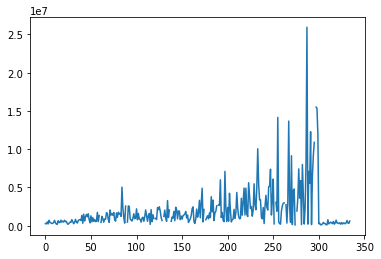

In [53]:
# plot
enginepower = data.groupby(['enginePower'])['price'].mean().reset_index()
plt.plot(enginepower['price'])

### 2.7 fuelType
- replaced empty vlaues (checked the description to find more information, found nothing, replaced with values with values common for the model and production year)
- there is very low number of values in hybrid and gaz cars
- disel has a higher price range

In [54]:
feature_info('fuelType')

TRAIN dataset: 
number of unique values in feature 
 6
unique vlaues ['бензин' 'дизель' 'гибрид' 'электро' 'газ' nan]
number of NANs 
 2
TEST dataset: 
number of unique values in feature 
 5
unique vlaues ['бензин' 'дизель' 'гибрид' 'электро' 'газ' nan]
number of NANs 
 2


In [55]:
#check the information about the car
data[data['fuelType'].isna() == True]['description']

76909     Продаю Honda Civic Suttle 1989 г. выпуска, неу...
121955                          В хорошем состоянии на ходу
Name: description, dtype: object

In [56]:
print(data.iloc[76909,3])
print(data.iloc[121955,3])

Продаю Honda Civic Suttle 1989 г. выпуска, неубиваемая рабочая лошадка со спортивным норовом. Потрясающая динамика, проходимость и управляемость. Требует небольшие сварочные работы (замена порогов). Имеется  еще запасной капот и  кардан. Возможен торг при осмотре.
В хорошем состоянии на ходу


In [57]:
#replace epmty values
data['fuelType'] = data.fuelType.fillna('бензин')

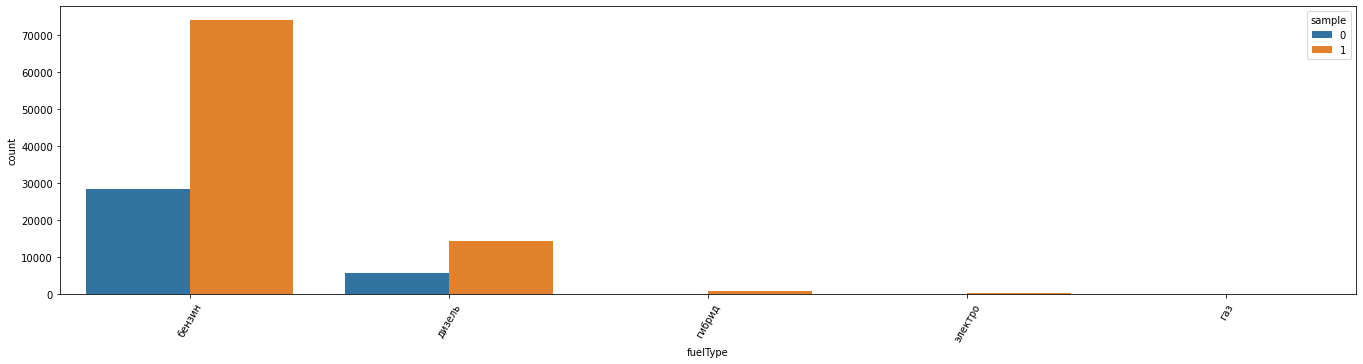

In [58]:
barplot_function('fuelType')

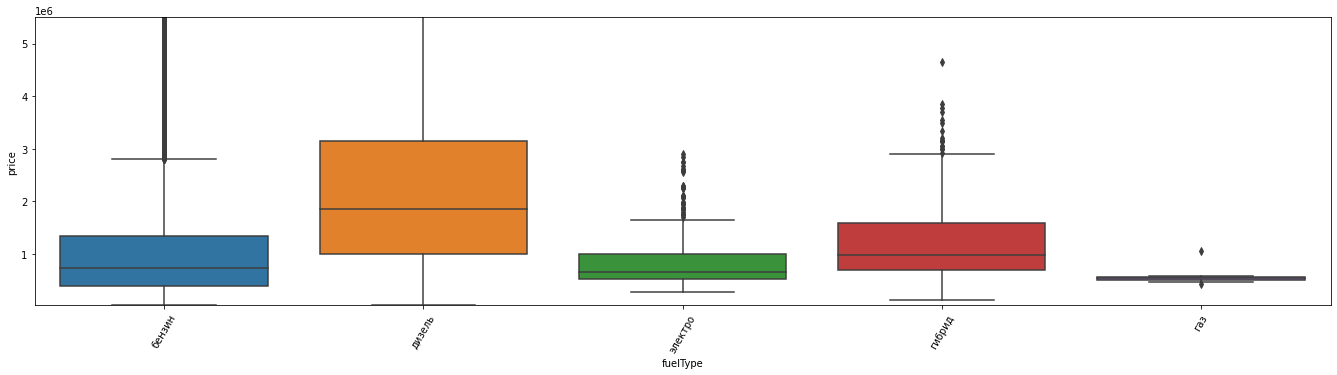

In [59]:
boxplot_function('fuelType')

### 2.7 mileage
as expected , there is negative correlation between price and mileage: 
> as higher mileage is as lower price

In [60]:
feature_info('mileage')

TRAIN dataset: 
number of unique values in feature 
 21944
unique vlaues [ 74000  60563  88000 ... 130478  93199 169805]
number of NANs 
 0
TEST dataset: 
number of unique values in feature 
 11268
unique vlaues [ 74000  60563  88000 ... 130478  93199 169805]
number of NANs 
 0


In [61]:
# scater plot between price and mileage
fig = px.scatter(data, x="mileage", y="price")
fig.show()

### 2.8 model_name
- there are no NaN'a
- in prepare dataset brought the model names in train dataset to the same format like in test

In [62]:
feature_info('model_name')

TRAIN dataset: 
number of unique values in feature 
 471
unique vlaues ['OCTAVIA' 'SUPERB' 'OCTAVIA_RS' 'YETI' 'KODIAQ' 'RAPID' 'FABIA'
 'ROOMSTER' 'FELICIA' 'KAROQ' 'FABIA_RS' '120' '100_SERIES' 'FAVORIT'
 'POPULAR' 'Q5' 'R8' 'Q7' 'Q3' 'A4' 'A3' 'A5' 'A6' 'RS7' 'S6' 'RS6'
 'ALLROAD' 'TT' 'S5' 'S8' 'A1' 'A8' '80' 'A7' 'RSQ3' 'RS3' 'A4_ALLROAD'
 'Q8' '100' 'SQ5' 'S4' 'TT_RS' 'RS4' 'S7' 'RS5' '90' 'COUPE' 'A2' 'TTS'
 '920' 'S3' '200' 'V8' 'E_TRON' 'CR_V' 'ACCORD' 'PILOT' 'CIVIC' 'ODYSSEY'
 'STREAM' 'CROSSTOUR' 'ELYSION' 'ELEMENT' 'RIDGELINE' 'FIT' 'HR_V'
 'SHUTTLE' 'FREED' 'ODYSSEY_NA' 'JAZZ' 'Z' 'CIVIC_FERIO' 'S2000' 'CR_Z'
 'LEGEND' 'STEPWAGON' 'CIVIC_TYPE_R' 'FR_V' 'CR_X' 'PRELUDE'
 'MOBILIO_SPIKE' 'N_BOX' 'ZEST' 'INTEGRA' 'INSPIRE' 'VEZEL' 'N_WGN'
 'ASCOT' 'LOGO' 'ACTY' 'CONCERTO' 'AVANCIER' 'SABER' 'MOBILIO' 'CROSSROAD'
 'INSIGHT' 'TORNEO' 'AIRWAVE' 'DOMANI' 'RAFAGA' 'CITY' 'VIGOR' 'ORTHIA'
 'PARTNER' 'V60_CROSS_COUNTRY' 'XC40' 'XC60' 'C30' 'V50' 'XC90'
 'V90_CROSS_COUNTRY' 'S60' 'X

### 2.9 productionDate
- no empty values
- as higher prouction year is as higher is the price. 
- there are some old cars with high price range, could be retro cars

In [63]:
feature_info('productionDate')

TRAIN dataset: 
number of unique values in feature 
 71
unique vlaues [2014 2017 2012 2011 2019 2018 2010 2020 2016 2013 2006 2007 2015 2005
 2008 2009 1997 2004 2002 1987 2003 2001 1976 2000 1998 1995 1999 1993
 1939 1996 1984 1990 1991 1992 1989 1982 1985 1994 1938 1981 1988 1983
 1980 1986 1978 1970 1979 1977 1972 1975 1969 1950 1953 1949 1937 1959
 1968 1936 1904 1974 1967 1961 1960 1965 1963 1957 1952 1973 1948 2021
 1940 1934 1964 1958]
number of NANs 
 0
TEST dataset: 
number of unique values in feature 
 69
unique vlaues [2014 2017 2012 2011 2019 2018 2010 2020 2016 2013 2006 2007 2015 2005
 2008 2009 1997 2004 2002 1987 2003 2001 1976 2000 1998 1995 1999 1993
 1939 1996 1984 1990 1991 1992 1989 1982 1985 1994 1938 1981 1988 1983
 1980 1986 1978 1970 1979 1977 1972 1975 1969 1950 1953 1949 1937 1959
 1968 1936 1904 1974 1967 1961 1960 1965 1963 1957 1952 1973 1948 2021
 1940 1934 1964 1958]
number of NANs 
 0


In [64]:
# scater plot between price and mileage
fig = px.scatter(data, x="productionDate", y="price")
fig.show()

### 2.10 vehicleTransmission
- replaced empty values
- automatic cars have a higher price range

In [65]:
feature_info('vehicleTransmission')

TRAIN dataset: 
number of unique values in feature 
 5
unique vlaues ['роботизированная' 'механическая' 'автоматическая' 'вариатор' nan]
number of NANs 
 2
TEST dataset: 
number of unique values in feature 
 4
unique vlaues ['роботизированная' 'механическая' 'автоматическая' 'вариатор' nan]
number of NANs 
 2


In [66]:
# check the information about the car
data[data['vehicleTransmission'].isna() == True]

bodyType  brand        color  \
76909   хэтчбек 3 дв.  HONDA  серебристый   
121955  хэтчбек 3 дв.  HONDA    пурпурный   

                                              description engineDisplacement  \
76909   Продаю Honda Civic Suttle 1989 г. выпуска, неу...            1.3 LTR   
121955                        В хорошем состоянии на ходу            1.3 LTR   

       enginePower fuelType  mileage model_name  productionDate  ...  \
76909       75 N12   бензин   400000      CIVIC            1989  ...   
121955      75 N12   бензин   220000      CIVIC            1989  ...   

                                                     text  \
76909   [продаю, honda, civic, suttle, г, выпуска, неу...   
121955                  [в, хорошем, состоянии, на, ходу]   

       подушки безопасности обогрев хорошем состоянии кондиционер  \
76909                     0       0                 0           0   
121955                    0       0                 1           0   

       обслуживание датчик электропривод  юридической  круизконтроль  
76909             0      0             0            0              0  
121955            0      0             0            0              0  

[2 rows x 30 columns]

In [67]:
# fill names with most common value for this brand and model
data[((data['brand'] == 'HONDA') & (data['model_name']
                                    == 'CIVIC') & (data['productionDate'] == 1989))].T

32043   \
bodyType                                                  хэтчбек 3 дв.   
brand                                                             HONDA   
color                                                       серебристый   
description           Всем привет, продам квадрат. \nБыл куплен мной...   
engineDisplacement                                              1.4 LTR   
enginePower                                                      90 N12   
fuelType                                                         бензин   
mileage                                                          285366   
model_name                                                        CIVIC   
productionDate                                                     1989   
vehicleTransmission                                      автоматическая   
vendor                                                         JAPANESE   
Владельцы                                                   3 или более   
ПТС                                                            Дубликат   
Привод                                                         передний   
Руль                                                              Левый   
Состояние                                            Не требует ремонта   
Таможня                                                      Растаможен   
sample                                                                0   
price                                                               NaN   
text                  [всем, привет, продам, квадрат, был, куплен, м...   
подушки безопасности                                                  0   
обогрев                                                               0   
хорошем состоянии                                                     0   
кондиционер                                                           0   
обслуживание                                                          0   
датчик                                                                0   
электропривод                                                         0   
юридической                                                           0   
круизконтроль                                                         0   

                                                                 76430   \
bodyType                                                  хэтчбек 3 дв.   
brand                                                             HONDA   
color                                                             белый   
description           Официальный дилерский центр РОЛЬФ Сити | Автом...   
engineDisplacement                                              1.3 LTR   
enginePower                                                      75 N12   
fuelType                                                         бензин   
mileage                                                          378644   
model_name                                                        CIVIC   
productionDate                                                     1989   
vehicleTransmission                                        механическая   
vendor                                                         JAPANESE   
Владельцы                                                   3 или более   
ПТС                                                            Оригинал   
Привод                                                         передний   
Руль                                                              Левый   
Состояние                                            Не требует ремонта   
Таможня                                                      Растаможен   
sample                                                                1   
price                                                            170000   
text                  [официальный, дилерский, центр, рольф, сити, а...   
подушки безопасности                                                  0   
обогрев       

In [68]:
# replace epmty values
data['vehicleTransmission'] = data.vehicleTransmission.fillna('механическая')

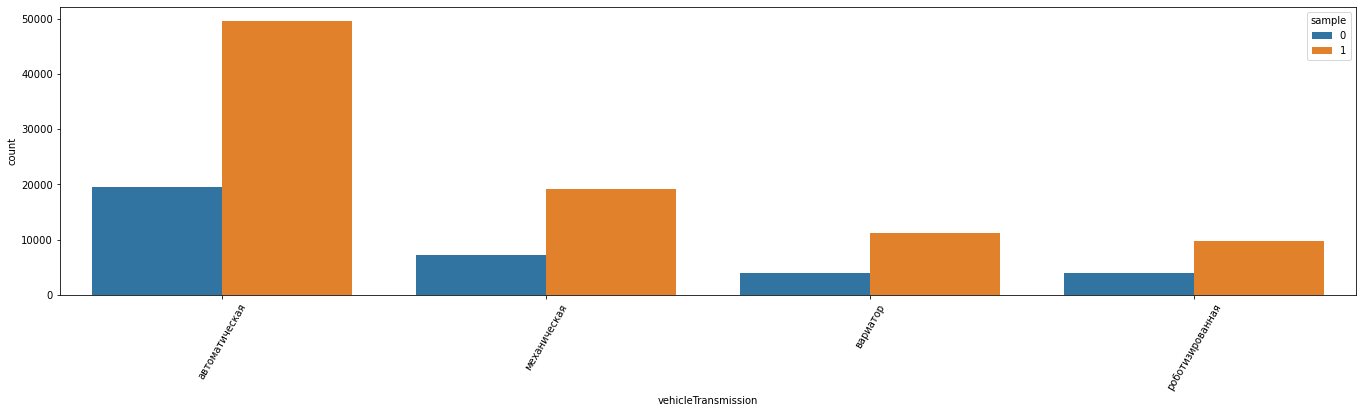

In [69]:
barplot_function('vehicleTransmission')

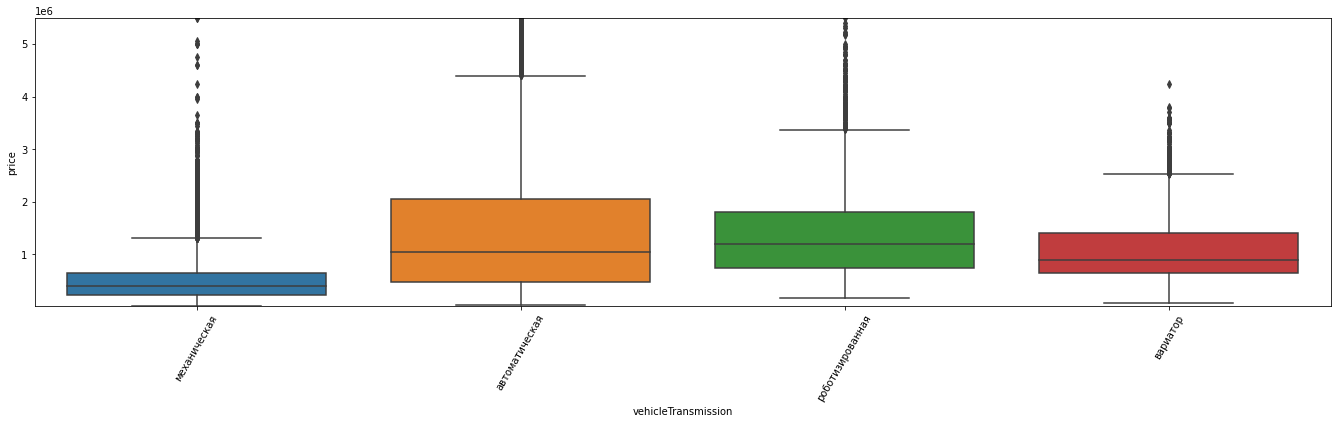

In [70]:
boxplot_function('vehicleTransmission')

### 2.11 vendor
- looks like vendor have no influence on price - thinking to delete this feature

In [71]:
feature_info('vendor')

TRAIN dataset: 
number of unique values in feature 
 2
unique vlaues ['EUROPEAN' 'JAPANESE']
number of NANs 
 0
TEST dataset: 
number of unique values in feature 
 2
unique vlaues ['EUROPEAN' 'JAPANESE']
number of NANs 
 0


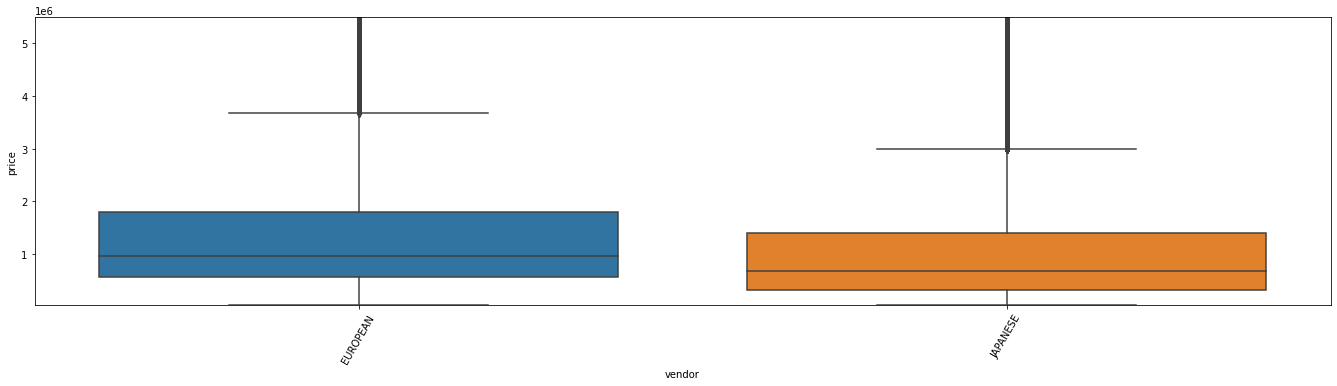

In [72]:
boxplot_function('vendor')

### 2.12 Владельцы
- replced empty vlaues with common values for this production Year
- as higher number of owner is as lower is the price, but in could be the reason as hihger the number of owner is as older is a car 
- check for correlation between the features

In [73]:
feature_info('Владельцы')

TRAIN dataset: 
number of unique values in feature 
 4
unique vlaues ['3 или более' '1\xa0владелец' '2\xa0владельца' nan]
number of NANs 
 5
TEST dataset: 
number of unique values in feature 
 3
unique vlaues ['3 или более' '1\xa0владелец' '2\xa0владельца' nan]
number of NANs 
 5


In [74]:
# replace some unusual string
data['Владельцы'] = data['Владельцы'].str.replace('\xa0', ' ')

In [75]:
# check NaN's
data[data['Владельцы'].isna() == True]

bodyType  brand    color  \
36444          седан   AUDI   чёрный   
37122  хэтчбек 5 дв.    BMW  красный   
52314     компактвэн  HONDA    белый   
78992          седан   AUDI   чёрный   
79661  хэтчбек 5 дв.    BMW  красный   

                                             description engineDisplacement  \
36444  Тех / обслуживание каждые 10т км , последнее т...            2.4 LTR   
37122  Очень динамичный автомобиль для города,за врем...            1.6 LTR   
52314  Газ бензин. Состояние отличное к концу месяца ...            2.3 LTR   
78992  Тех / обслуживание каждые 10т км , последнее т...            2.4 LTR   
79661  Очень динамичный автомобиль для города,за врем...            1.6 LTR   

      enginePower fuelType  mileage model_name  productionDate  ...  \
36444     177 N12   бензин    91600         A6            2007  ...   
37122     115 N12   бензин   150000          1            2008  ...   
52314     150 N12   бензин   158000    ODYSSEY            2003  ...   
78992     177 N12   бензин    91600         A6            2007  ...   
79661     115 N12   бензин   150000          1            2008  ...   

                                                    text подушки безопасности  \
36444  [тех, обслуживание, каждые, км, последнее, то,...                    0   
37122  [очень, динамичный, автомобиль, для, города, з...                    0   
52314  [газ, бензин, состояние, отличное, к, концу, м...                    0   
78992  [тех, обслуживание, каждые, км, последнее, то,...                    0   
79661  [очень, динамичный, автомобиль, для, города, з...                    0   

      обогрев хорошем состоянии кондиционер обслуживание датчик электропривод  \
36444       0                 0           0            1      0             0   
37122       0                 0           0            0      0             0   
52314       0                 0           0            0      0             0   
78992       0                 0           0            1      0             0   
79661       0                 0           0            0      0             0   

       юридической  круизконтроль  
36444            0              0  
37122            0              0  
52314            0              0  
78992            0              0  
79661            0              0  

[5 rows x 30 columns]

In [76]:
data[((data['productionDate'] == 2007) | (data['productionDate'] == 2008) | (
    data['productionDate'] == 2003))].groupby(['productionDate', 'Владельцы'])['Владельцы'].count()

productionDate  Владельцы  
2003            1 владелец      137
                2 владельца     389
                3 или более    2159
2007            1 владелец      487
                2 владельца    1219
                3 или более    4255
2008            1 владелец      843
                2 владельца    1927
                3 или более    5074
Name: Владельцы, dtype: int64

In [77]:
# replace epmty values
data['Владельцы'] = data.Владельцы.fillna('3 или более')

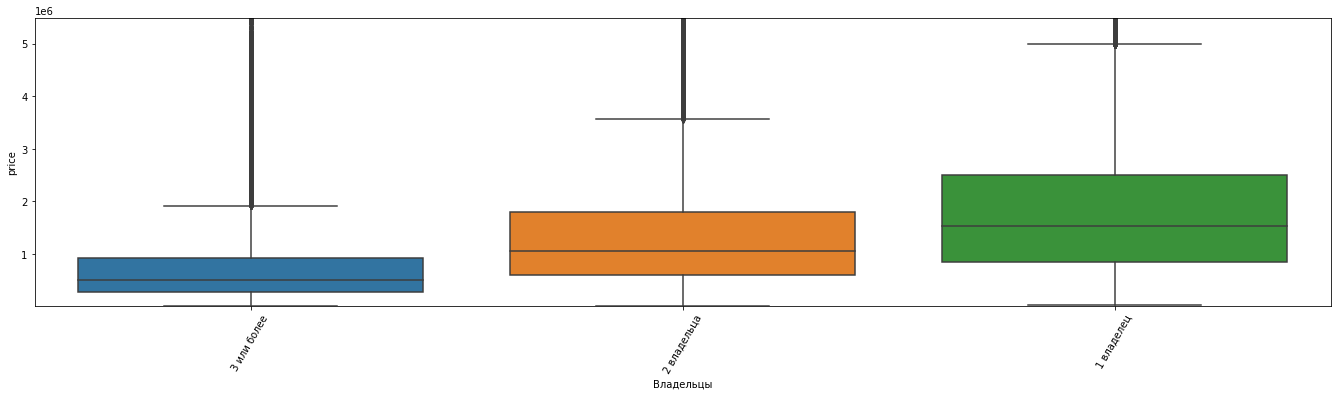

In [78]:
boxplot_function('Владельцы')

### 2.13 ПТС
- replaced empty values
- original has the higher price rnage than duplicate

In [79]:
feature_info('ПТС')

TRAIN dataset: 
number of unique values in feature 
 3
unique vlaues ['Оригинал' 'Дубликат' nan]
number of NANs 
 3
TEST dataset: 
number of unique values in feature 
 3
unique vlaues ['Оригинал' 'Дубликат' nan]
number of NANs 
 3


In [80]:
# check NaN's
data[data['ПТС'].isna() == True]

bodyType       brand    color  \
10412    седан         BMW    синий   
38781    седан        AUDI   чёрный   
71749    седан  MITSUBISHI  зелёный   

                                             description engineDisplacement  \
10412  Сделано большое Т.О. Фильтра масляный, воздушн...            2.5 LTR   
38781  Отличное состояние. ДВС и АКПП без ошибок и за...            4.2 LTR   
71749  Машина на ходу, подробная информация при осмот...            1.6 LTR   

      enginePower fuelType  mileage model_name  productionDate  ...  \
10412     170 N12   бензин   276000        3ER            1999  ...   
38781     360 N12   бензин   250000         S8            2000  ...   
71749     100 N12   бензин   210000    CARISMA            2000  ...   

                                                    text подушки безопасности  \
10412  [сделано, большое, т, о, фильтра, масляный, во...                    0   
38781  [отличное, состояние, двс, и, акпп, без, ошибо...                    0   
71749  [машина, на, ходу, подробная, информация, при,...                    0   

      обогрев хорошем состоянии кондиционер обслуживание датчик электропривод  \
10412       0                 0           0            0      0             0   
38781       0                 0           0            0      0             0   
71749       0                 0           0            0      0             0   

       юридической  круизконтроль  
10412            0              0  
38781            0              0  
71749            0              0  

[3 rows x 30 columns]

In [81]:
data.groupby(['ПТС', 'brand'])['ПТС'].count()

ПТС       brand     
Дубликат  AUDI           2188
          BMW            2289
          HONDA          1242
          INFINITI        451
          LEXUS           431
          MERCEDES       2090
          MITSUBISHI     1562
          NISSAN         2526
          SKODA           952
          TOYOTA         2863
          VOLKSWAGEN     1611
          VOLVO           763
Оригинал  AUDI           9415
          BMW           12108
          HONDA          4739
          INFINITI       1975
          LEXUS          2886
          MERCEDES      11602
          MITSUBISHI     7525
          NISSAN        14704
          SKODA          9315
          TOYOTA        14917
          VOLKSWAGEN    12593
          VOLVO          3604
Name: ПТС, dtype: int64

In [82]:
# replace epmty common value for that car brand values
data['ПТС'] = data.ПТС.fillna('Оригинал')

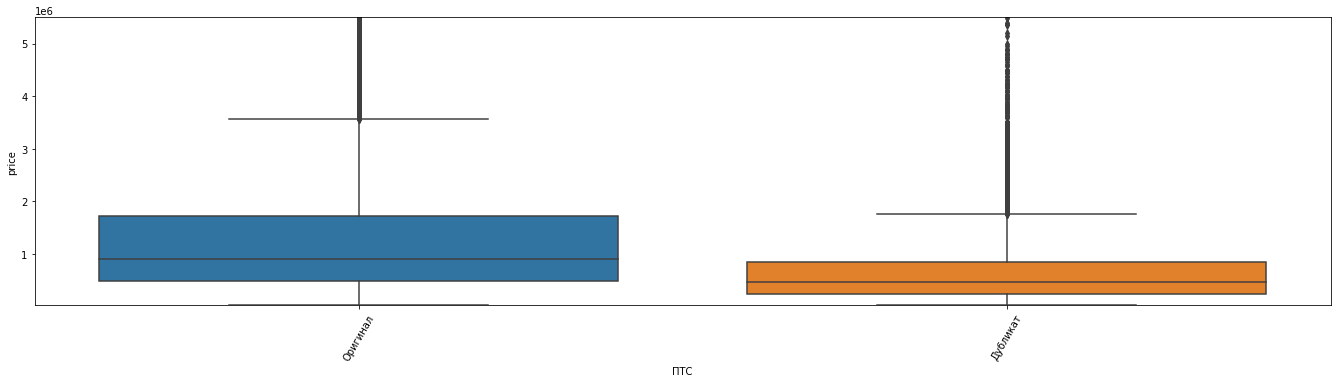

In [83]:
boxplot_function('ПТС')

### 2.14 Привод
- replaced empty values
- there are differences in price range and drive

In [84]:
feature_info('Привод')

TRAIN dataset: 
number of unique values in feature 
 4
unique vlaues ['передний' 'полный' 'задний' nan]
number of NANs 
 2
TEST dataset: 
number of unique values in feature 
 3
unique vlaues ['передний' 'полный' 'задний' nan]
number of NANs 
 2


In [85]:
# check NaN's
data[data['Привод'].isna() == True]

bodyType  brand        color  \
76909   хэтчбек 3 дв.  HONDA  серебристый   
121955  хэтчбек 3 дв.  HONDA    пурпурный   

                                              description engineDisplacement  \
76909   Продаю Honda Civic Suttle 1989 г. выпуска, неу...            1.3 LTR   
121955                        В хорошем состоянии на ходу            1.3 LTR   

       enginePower fuelType  mileage model_name  productionDate  ...  \
76909       75 N12   бензин   400000      CIVIC            1989  ...   
121955      75 N12   бензин   220000      CIVIC            1989  ...   

                                                     text  \
76909   [продаю, honda, civic, suttle, г, выпуска, неу...   
121955                  [в, хорошем, состоянии, на, ходу]   

       подушки безопасности обогрев хорошем состоянии кондиционер  \
76909                     0       0                 0           0   
121955                    0       0                 1           0   

       обслуживание датчик электропривод  юридической  круизконтроль  
76909             0      0             0            0              0  
121955            0      0             0            0              0  

[2 rows x 30 columns]

In [86]:
# replace epmty common value for that car brand values
data['Привод'] = data.Привод.fillna('передний')

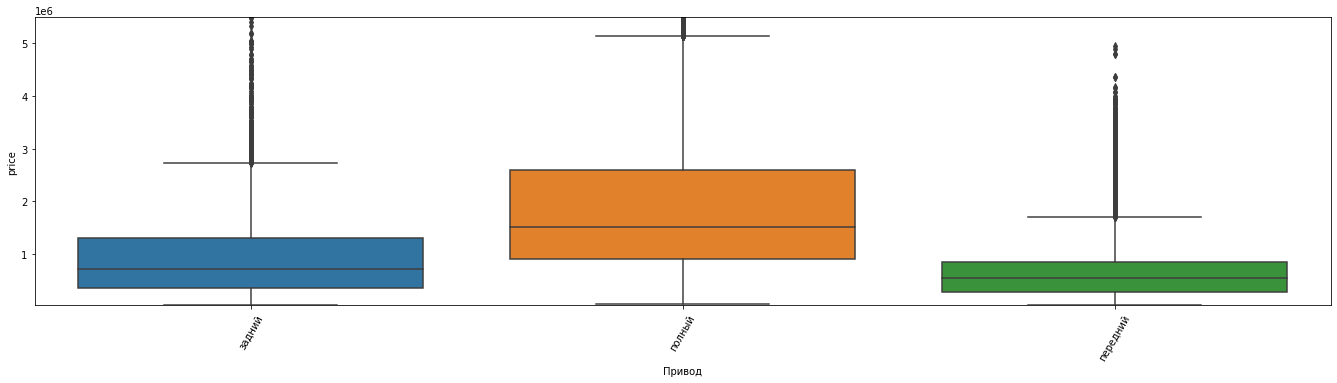

In [87]:
boxplot_function('Привод')

### 2.14 Руль
- no empty values
- left steering wheel  has higher price range

In [88]:
feature_info('Руль')

TRAIN dataset: 
number of unique values in feature 
 2
unique vlaues ['Левый' 'Правый']
number of NANs 
 0
TEST dataset: 
number of unique values in feature 
 2
unique vlaues ['Левый' 'Правый']
number of NANs 
 0


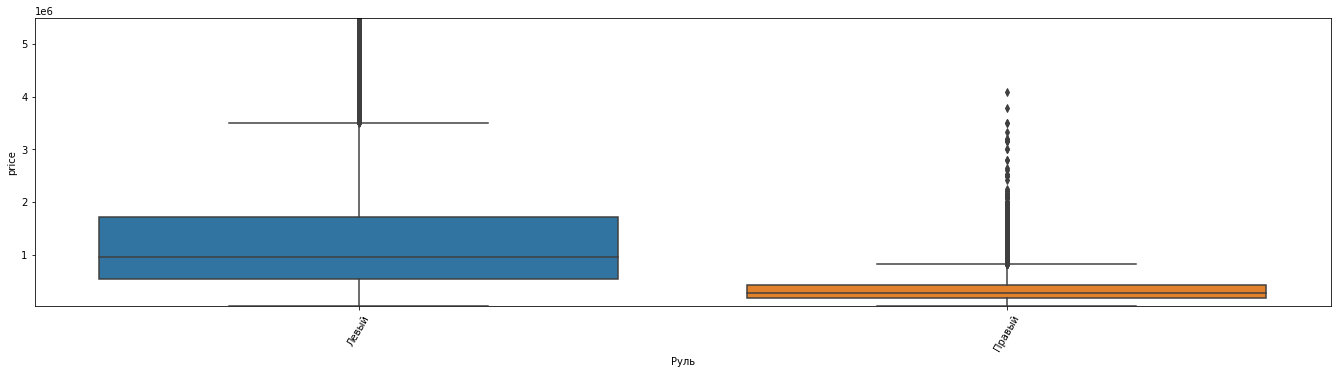

In [89]:
boxplot_function('Руль')

### 2.15 Состояние
- no empty vlaues
- car in bad condition have lower price range, is expected

In [90]:
feature_info('Состояние')

TRAIN dataset: 
number of unique values in feature 
 2
unique vlaues ['Не требует ремонта' 'Битый / не на ходу']
number of NANs 
 0
TEST dataset: 
number of unique values in feature 
 1
unique vlaues ['Не требует ремонта' 'Битый / не на ходу']
number of NANs 
 0


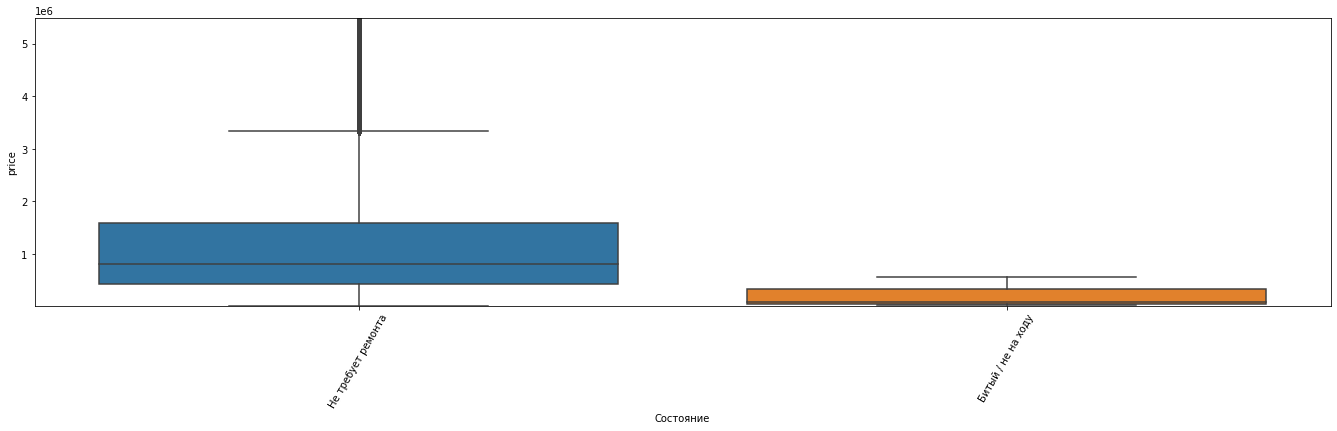

In [91]:
boxplot_function('Состояние')

### 2.16 Таможня 

In [92]:
feature_info('Таможня')

TRAIN dataset: 
number of unique values in feature 
 2
unique vlaues ['Растаможен' 'Не растаможен']
number of NANs 
 0
TEST dataset: 
number of unique values in feature 
 1
unique vlaues ['Растаможен' 'Не растаможен']
number of NANs 
 0


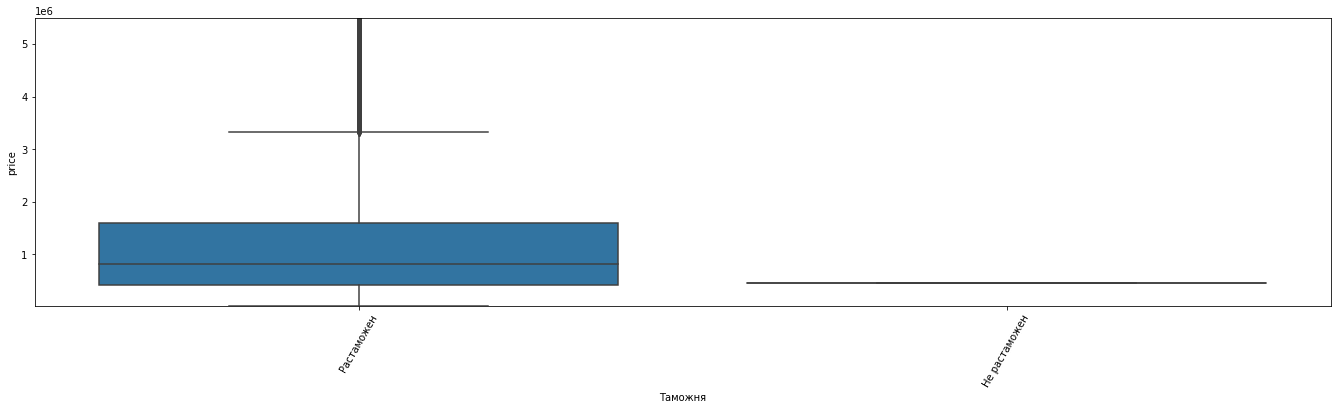

In [93]:
boxplot_function('Таможня')

In [94]:
# delete 'description', 'vendor' as there is no differences in price desctribution withing the vandor. 
# description was transformed to some other features
data = data.drop(columns=['description', 'vendor'])

## Check correlation
- delete some features with vary low correlation 
- as we don't have many numeric features we can not build correlation matrix for all features
 > there is high correlation between mileage and production date, what is understandible
- one hot encoding

## Label Encoding

In [96]:
label_encoder = LabelEncoder()
for column in cat_cols:
    data[column] = label_encoder.fit_transform(data[column])

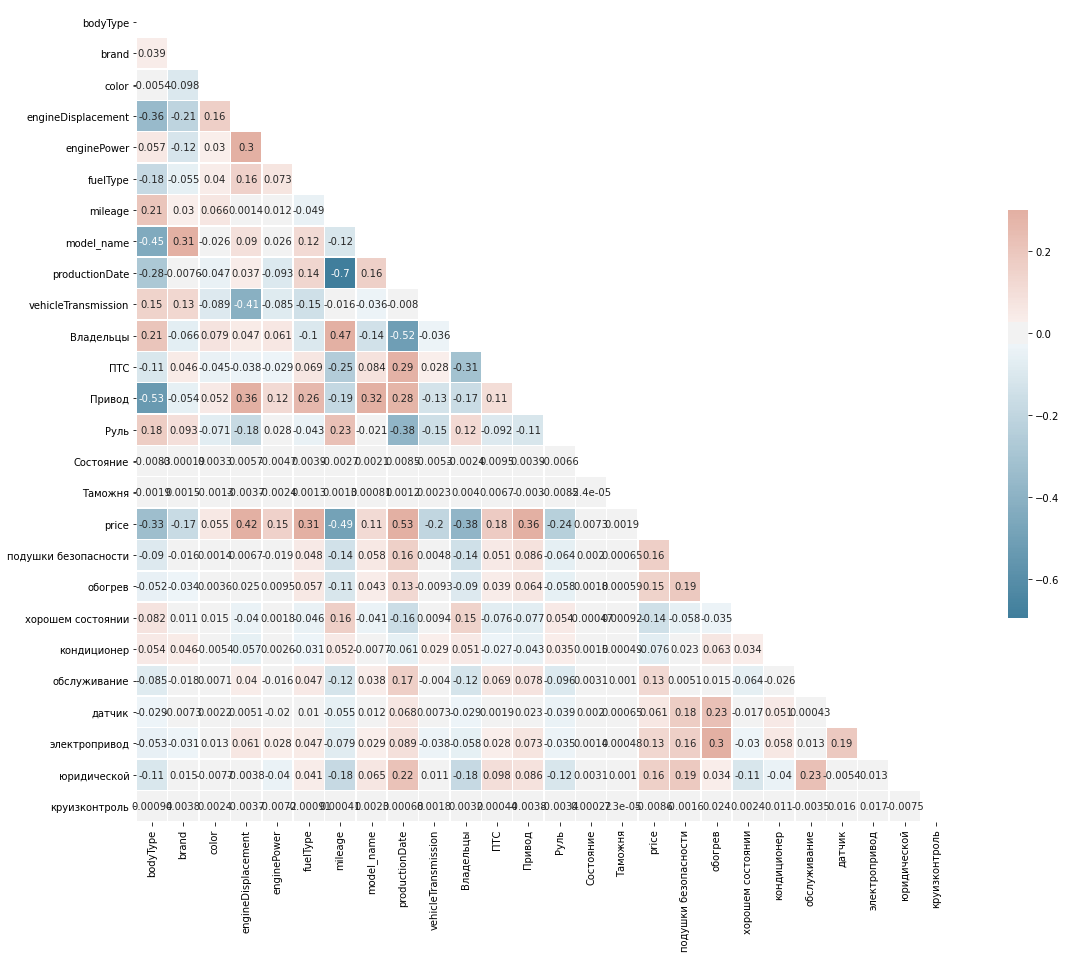

In [100]:
# correlation matrix
data_corr = data[data['sample'] == 1]
data_corr = data.drop(['text', 'sample'], axis=1)
corr = data_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [101]:
# delete unrelevant features
X = data.drop(['price', 'text', 'Состояние',
               'Таможня', 'круизконтроль'], axis=1)

In [102]:
# split features by type
cat_cols = ['bodyType', 'brand', 'color', 'engineDisplacement',
            'enginePower', 'fuelType', 'model_name',
            'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль']
bin_cols = ['подушки безопасности', 'обогрев', 'хорошем состоянии', 'кондиционер',
            'обслуживание', 'датчик', 'электропривод', 'юридической']

num_cols = ['mileage', 'productionDate']

In [103]:
# split datasets (drop unrelevant features)
X = data.drop(['price', 'text'], axis=1)
X_submit = X[X['sample'] == 0]
X = X[X['sample'] == 1]

X_submit = X_submit.drop(['sample'], axis=1)
X = X.drop(['sample'], axis=1)

# split data into test and validation datasets
y = data[data['sample'] == 1]['price']
y = y.apply(lambda x: math.log(x)).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

X_train = StandardScaler().fit_transform(X_train.values)
X_test = StandardScaler().fit_transform(X_test.values)
X_submit = StandardScaler().fit_transform(X_submit.values)

# ModelLing: 
## CatBoost
- test shown that logarithm of tagret variable has a better perfornamence about 14%
Result:
 > - MAPE: 0.90%
 > - Kaggle Score 19.26

In [104]:
model = CatBoostRegressor(iterations=5000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
model.fit(X_train, y_train,
          # cat_features=cat_features_ids,
          eval_set=(X_test, y_test),
          verbose_eval=0,
          use_best_model=True,
          # plot=True
          )

model.save_model('catboost_single_model_baseline.model')

## LGBMRegressor
Results:
 > - Точность модели по метрике MAPE: 1.03%
 > - Kaggle Leaderboard: 20.13668


In [126]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

model = LGBMRegressor(objective='regression', max_depth=12, num_leaves=2000,
                      learning_rate=0.025, n_estimators=28000, feature_fraction=0.6)
model.fit(X_train, y_train)
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 1.03%


In [127]:
predict_submission = np.exp(model.predict(X_submit))
predict_submission
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

sell_id         price
0  1100575026  6.282556e+05
1  1100549428  1.011624e+06
2  1100658222  9.526681e+05
3  1100937408  7.390092e+05
4  1101037972  8.359842e+05
5  1100912634  7.346648e+05
6  1101228730  8.552986e+05
7  1100165896  4.802984e+05
8  1100768262  2.030619e+06
9  1101218501  1.029882e+06

## GradientBoostingRegressor
> - Точность модели по метрике MAPE: 0.95%
> - Kaggle Score: 20.56541

In [128]:
model = GradientBoostingRegressor(
    min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=1000)
model.fit(X_train, y_train)

# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 0.95%


In [129]:
predict_submission = np.exp(model.predict(X_submit))
predict_submission
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

sell_id         price
0  1100575026  7.701038e+05
1  1100549428  9.972290e+05
2  1100658222  9.494818e+05
3  1100937408  7.388665e+05
4  1101037972  8.132321e+05
5  1100912634  6.240623e+05
6  1101228730  7.371185e+05
7  1100165896  5.297688e+05
8  1100768262  2.089459e+06
9  1101218501  9.701038e+05

## Ensembling

In [138]:
estimators = [('b_gbr', BaggingRegressor(GradientBoostingRegressor(random_state=RANDOM_SEED, n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features='sqrt', max_depth=9),
                                         n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)), ('xgb', xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05, max_depth=12, alpha=1, n_estimators=1000))]

model = StackingRegressor(estimators=estimators, final_estimator=CatBoostRegressor(iterations=5000, random_seed=RANDOM_SEED,
                                                                                   eval_metric='MAPE', custom_metric=['R2', 'MAE'], silent=True, learning_rate=0.13, depth=12, l2_leaf_reg=8, random_strength=0.3))


model.fit(X_train, np.log(y_train))
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

predict_submission = np.exp(model.predict(X_submit))
predict_submission
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

Точность модели по метрике MAPE: 80.76%


sell_id      price
0  1100575026  13.423583
1  1100549428  13.970155
2  1100658222  13.767933
3  1100937408  13.472367
4  1101037972  13.608509
5  1100912634  13.435095
6  1101228730  13.585626
7  1100165896  12.943516
8  1100768262  14.551028
9  1101218501  13.797000

# Comment:
- i spent a lot of time on parsing the data and that's wha didn't had enogn time to calculate and tune the model
- three algorithms which gave a "good" result are Catboost, LGBMRegressor and GradientBoostingRegressor. 
- Catboost had the better score on kaggle